# Overfitting

*In which we practice one thing so much that we get worse at everything else.*


### Define Constants


In [19]:
CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../1-models/models.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]


### Importing Libraries


In [20]:
from notebooks.time_for_crab.mlutils import display_df, score_comparator, score_model

import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


### Load Data from Cache

In the [previous section](../0-eda/eda.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [21]:
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs)


DataFrame shape: (3893, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3893 no

## Overfitting Crab Age

![Large mud crab measure](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg/1920px-CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg)


### Overfitting Goals and Methods 

The goal here is to show how complex of a model it will take to overfit the data.

We will use the following methods to overfit the data:

1. **Linear Regression**: Gradually increase the complexity of a linear regression model.
2. **Model Stacking**: Stack models to overfit the model.

> There are two steps in your single-variable linear regression model:  
>    1. Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
>    2. Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (tf.keras.layers.Dense).
>
> https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable 

Instead of 'Horsepower', we'll use 'Shell Weight' as the regression variable.


In [22]:
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)


### Build the Shell Weight Model

This is a simple linear regression model that predicts the age of a crab based on its shell weight. It remains untrained.


In [23]:
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)

shell_weight_model = keras.Sequential([
    keras.layers.Input(shape=(1,)),
    shell_weight_normalizer,
    keras.layers.Dense(units=1)
])

shell_weight_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

### Predict Before Training (For Science)

We don't expect good results here. This is just to get a baseline.


In [24]:
shell_weight_target = np.array(crabs['Age'])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
[9 6 6 ... 5 6 8]
[-0.00405773 -0.41849196 -0.32227704 ... -0.4921553  -0.3052658
 -0.42988482]


#### Scores Before Training

Throughout this notebook, we will use the following metrics to evaluate the regression model:

- **Explained Variance Score**: The best possible score is 1.0, lower values are worse.
- **Max Error**: The max error is the worst possible score.
- **Mean Squared Error**: The best possible score is 0.0, lower values are better.
- **R2 Score**: The best possible score is 1.0, lower values are worse.
 

In [25]:
naive_scores = score_model(shell_weight_preds, shell_weight_target)

naive_scores_df = pd.DataFrame(naive_scores, index=['naive'])
naive_scores_df.head()


,explained_variance_score,max_error,mean_squared_error,r2_score
naive,-91.710701,28.466877,108.302094,-1090.086989


#### Pre-Training Observations

As expected, the untrained scores are terrible.


### Compile the Model

Now it's finally time to get learning!

We will use the mean squared error as the loss function and the Adam optimizer.


In [26]:
shell_weight_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


### Train the Model

Let's train for 100 epochs.


In [27]:
%%time
history = shell_weight_model.fit(
    x=crabs['Shell Weight'],
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2
)


CPU times: total: 859 ms
Wall time: 8.07 s


### Plot the Training History


In [28]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()


,loss,val_loss,epoch
95,6.408494,6.244124,95
96,6.404539,6.247466,96
97,6.444561,6.153646,97
98,6.400075,6.483292,98
99,6.419083,6.181911,99


### Plot the Loss History


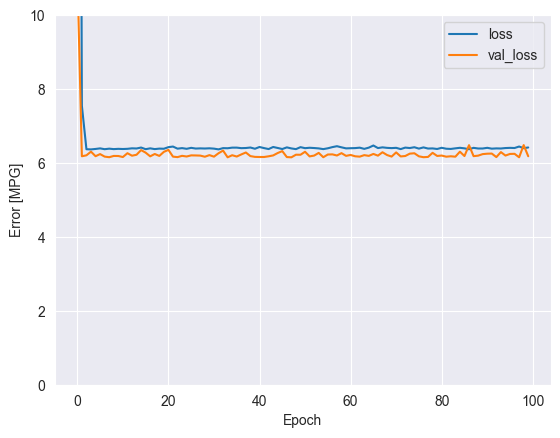

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


### Predict After Training

To see if training improved the model.


In [30]:
shell_weight_target = np.array(crabs['Age'])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
[9 6 6 ... 5 6 8]
[10.061938   7.2971125  7.9389935 ...  6.8056803  8.052481   7.2211075]


#### Scores After Training

- **Explained Variance Score**: The best possible score is 1.0, lower values are worse.
- **Max Error**: The max error is the worst possible score.
- **Mean Squared Error**: The best possible score is 0.0, lower values are better.
- **R2 Score**: The best possible score is 1.0, lower values are worse.
 

In [31]:
scores = score_model(shell_weight_preds, shell_weight_target)

scores_df = pd.DataFrame(scores, index=['train'])
scores_df.head()


,explained_variance_score,max_error,mean_squared_error,r2_score
train,-0.431923,15.354357,6.343745,-0.435966


"#### Post-Training Observations

The scores are better after training, but not by much. The model is still underfitting.

Shell weight alone must not be a good predictor of crab age.


#### Compare Pre- and Post-Training Predictions

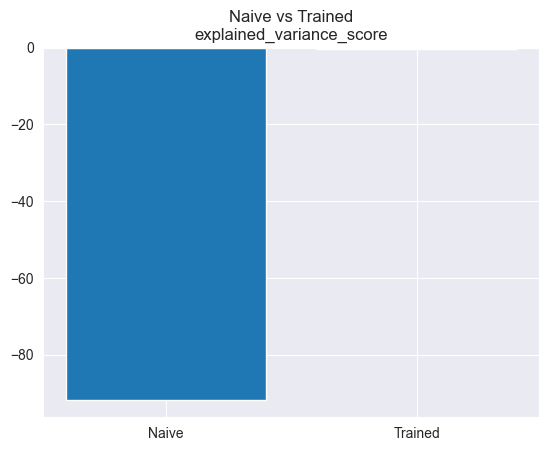

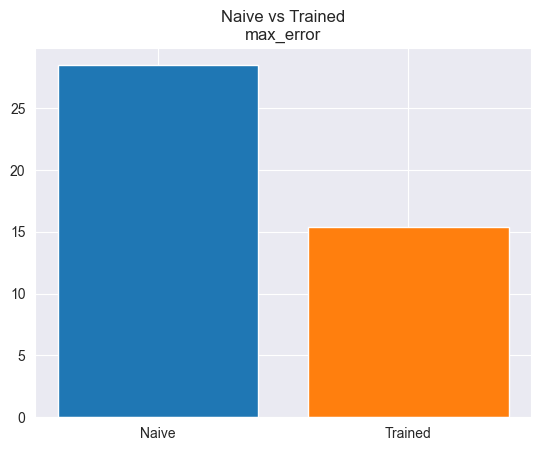

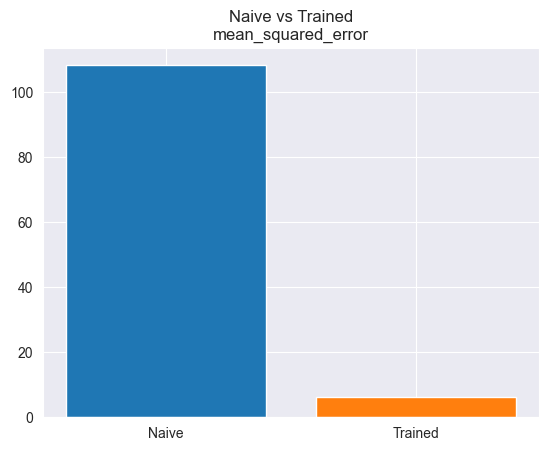

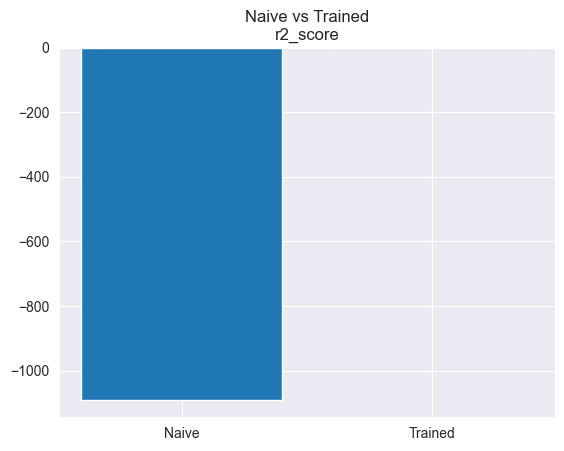

In [63]:
def score_comparator(
        train_scores:pd.DataFrame,
        test_scores:pd.DataFrame,
        train_label:str='Train',
        test_label:str='Test'
):
    """Plot the scores of two models to compare them.

    Disclaimer: Columns may or may not need to match.

    :param train_scores: The scores of the training model.
    :param test_scores: The scores of the testing model.
    :param train_label: The label for the training model. Default is 'Train'.
    :param test_label: The label for the testing model. Default is 'Test'.
    """
    
    for i, col in enumerate(train_scores.columns):
        plt.figure()
        plt.title(f'{train_label} vs {test_label}\n{col}')
        plt.bar(i*2, train_scores[col])
        plt.bar(i*2+1, test_scores[col])
        plt.xticks(ticks=[i*2, i*2+1], labels=[train_label, test_label])
    plt.show()
# Utility functions imported from mlutils.py
score_comparator(naive_scores_df, scores_df, train_label='Naive', test_label='Trained')


### Don't Save this Data

We don't want our over-trained model to leak into the [next step](../1-models/models.ipynb).


### Onwards to Model Selection

See the [next section](../1-models/models.ipynb) for model selection.
